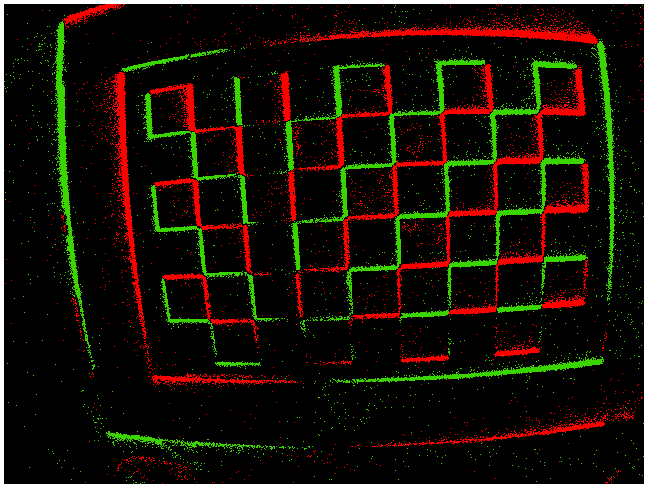

Parser took: 160 seconds.


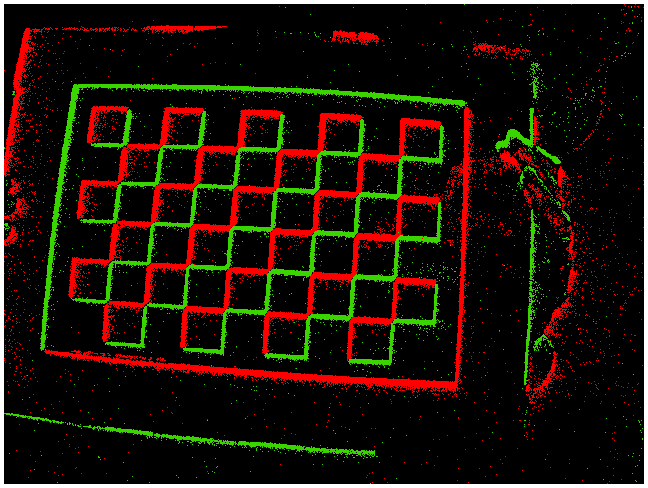

Parser took: 140 seconds.


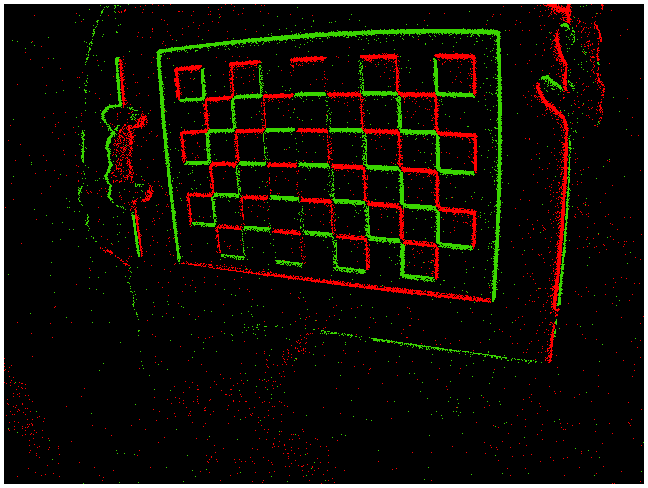

Parser took: 120 seconds.


In [5]:

%matplotlib inline


import sys, getopt
import pdb
import time
import cv2 as cv
import numpy as np
import pdb
import matplotlib.pyplot as plt
from utils import getNextRow, preprocess, print_all
from matplotlib.colors import LinearSegmentedColormap

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#FF0001-000000-3BD600
    (0.000, (1.000, 0.000, 0.004)),
    (0.500, (0.000, 0.000, 0.000)),
    (1.000, (0.231, 0.839, 0.000))))

'''
This code produces 1 image out of events every 17ms
Images are ignored when less than <activity>% of the pixels are inactive 
Among the used images, one will be stored after visual/manual inspection
The image to be stored need to be evidently affected by lens distortion
The distorted image is necesary to check distortion maps
'''

if __name__ == "__main__":
    
    for i in range(3):
        camera_id = i+1
        my_dpi = 40
        x_max = 640
        y_max = 480
        fps = 60
        activity = 1
        if camera_id != 2:
            image_of_interest = 255 
        else:
            image_of_interest = 166 
        change_interval = int(1000/fps)*1000 # 33 ms : 30Hz  

        screen = np.zeros((x_max, y_max),dtype=int)

        inputfile = "recordings/rec_cam"+ str(camera_id) + ".aedat4"
        nb_events = -1 # Use all the events in the recording (if necessary)

        start = time.time()

        line_count = 0 # event counter
        image_counter = 0 # frame counter
        for t, x, y, p in getNextRow(inputfile):    


            # Extract time offset
            if line_count == 0 :
                first_t = t
                t_next_change = change_interval

            t_relative = t - first_t # first event occurs at t=0

            # Visualize Stuff and Prepare for next frame
            if t_relative > t_next_change:

                inactive_pixels = np.sum(screen == 0)
                if inactive_pixels < int((100-activity)/100*x_max*y_max):
                    if image_counter == image_of_interest-1:
                        screen = preprocess(screen)   
                        fig = plt.figure(figsize=(x_max/my_dpi, y_max/my_dpi), dpi=my_dpi, frameon=False)    
                        ax = plt.Axes(fig, [0., 0., 1., 1.])
                        ax.set_axis_off()
                        fig.add_axes(ax)
                        ax.imshow(np.transpose(screen), cmap=my_gradient, aspect='auto')
                        fig.savefig("distorted_" + str(camera_id) + ".png")
                        plt.pause(1)
                    image_counter += 1
                    if image_counter >= image_of_interest:
                        break

                # Clear window
                screen = np.zeros((x_max, y_max),dtype=int)
                t_next_change += change_interval

            else:
                screen[x,y] += 2*p-1


            line_count += 1

            # Check if enough events have been parsed
            if (nb_events > 0) and (line_count > nb_events):
                # Stop parsing since nb_events reached
                break

        stop = time.time()

        elapsed = stop - start
        print("Parser took: " + str(int(elapsed)) + " seconds.")